In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt

matlab_file = 'test.mat'

Text(0, 0.5, 'Frequency')

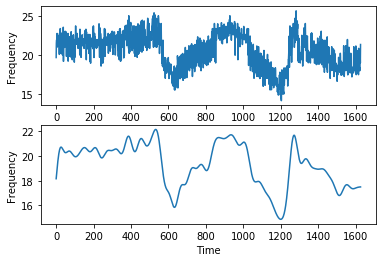

In [99]:
mat_contents = sio.loadmat(matlab_file)
antenna_1 = mat_contents['M']
subcarrier = 0   # Selected Subcarrier
fs = 1627        # Sampling Frequency
flt_ord = 12      # Filter order number

x_axis = []
y_axis = []
for i in range(0, len(antenna_1)):
    x_axis.append(i)
    y_axis.append(antenna_1[i][subcarrier])

# plt.specgram(y_axis, Fs=1000, cmap='viridis', NFFT=100, noverlap=99, scale_by_freq=True, xextent=(0,1.627))
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(y_axis)
ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')

b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
ax2.plot(output)
ax2.set_xlabel('Time')
ax2.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

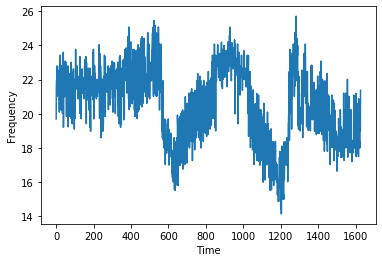

In [100]:
plt.plot(y_axis)
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

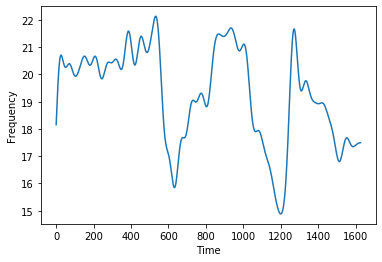

In [101]:
flt_ord = 12
b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

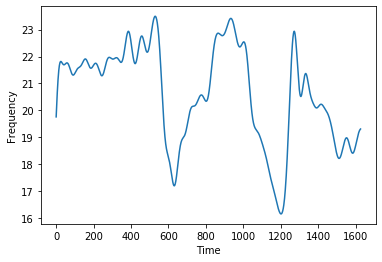

In [102]:
flt_ord = 5
b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Frequency')